In [15]:
import matplotlib.pyplot as plt
import random
from tqdm.auto import tqdm
import cv2
import numpy as np
from PIL import Image
import torch
from torch import nn, optim
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms, datasets, utils


In [16]:
## hyperparameter
batch_size =16
in_channels = 3
n_classes = 6
n_epochs = 80
lr = 1e-2
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [17]:
import glob 
import os
file_path = glob.glob('screw/test/*/*.png')
file_paths = [os.path.normpath(path) for path in file_path]
file_paths = sorted([path for path in file_paths if path.split(os.path.sep)[-1] in [f'{i:03}.png' for i in range(20)]])
print(file_paths)

['screw\\test\\good\\000.png', 'screw\\test\\good\\001.png', 'screw\\test\\good\\002.png', 'screw\\test\\good\\003.png', 'screw\\test\\good\\004.png', 'screw\\test\\good\\005.png', 'screw\\test\\good\\006.png', 'screw\\test\\good\\007.png', 'screw\\test\\good\\008.png', 'screw\\test\\good\\009.png', 'screw\\test\\good\\010.png', 'screw\\test\\good\\011.png', 'screw\\test\\good\\012.png', 'screw\\test\\good\\013.png', 'screw\\test\\good\\014.png', 'screw\\test\\good\\015.png', 'screw\\test\\good\\016.png', 'screw\\test\\good\\017.png', 'screw\\test\\good\\018.png', 'screw\\test\\good\\019.png', 'screw\\test\\manipulated_front\\000.png', 'screw\\test\\manipulated_front\\001.png', 'screw\\test\\manipulated_front\\002.png', 'screw\\test\\manipulated_front\\003.png', 'screw\\test\\manipulated_front\\004.png', 'screw\\test\\manipulated_front\\005.png', 'screw\\test\\manipulated_front\\006.png', 'screw\\test\\manipulated_front\\007.png', 'screw\\test\\manipulated_front\\008.png', 'screw\\test

In [18]:
all_data = []

for img in tqdm(file_paths):
    img = cv2.imread(img)
    img =img[...,::-1]
    all_data.append(img)

all_data = np.stack(all_data)
print(all_data.shape)

  0%|          | 0/120 [00:00<?, ?it/s]

100%|██████████| 120/120 [00:01<00:00, 87.01it/s]


(120, 1024, 1024, 3)


Classes: ['good', 'manipulated_front', 'scratch_head', 'scratch_neck', 'thread_side', 'thread_top']
20


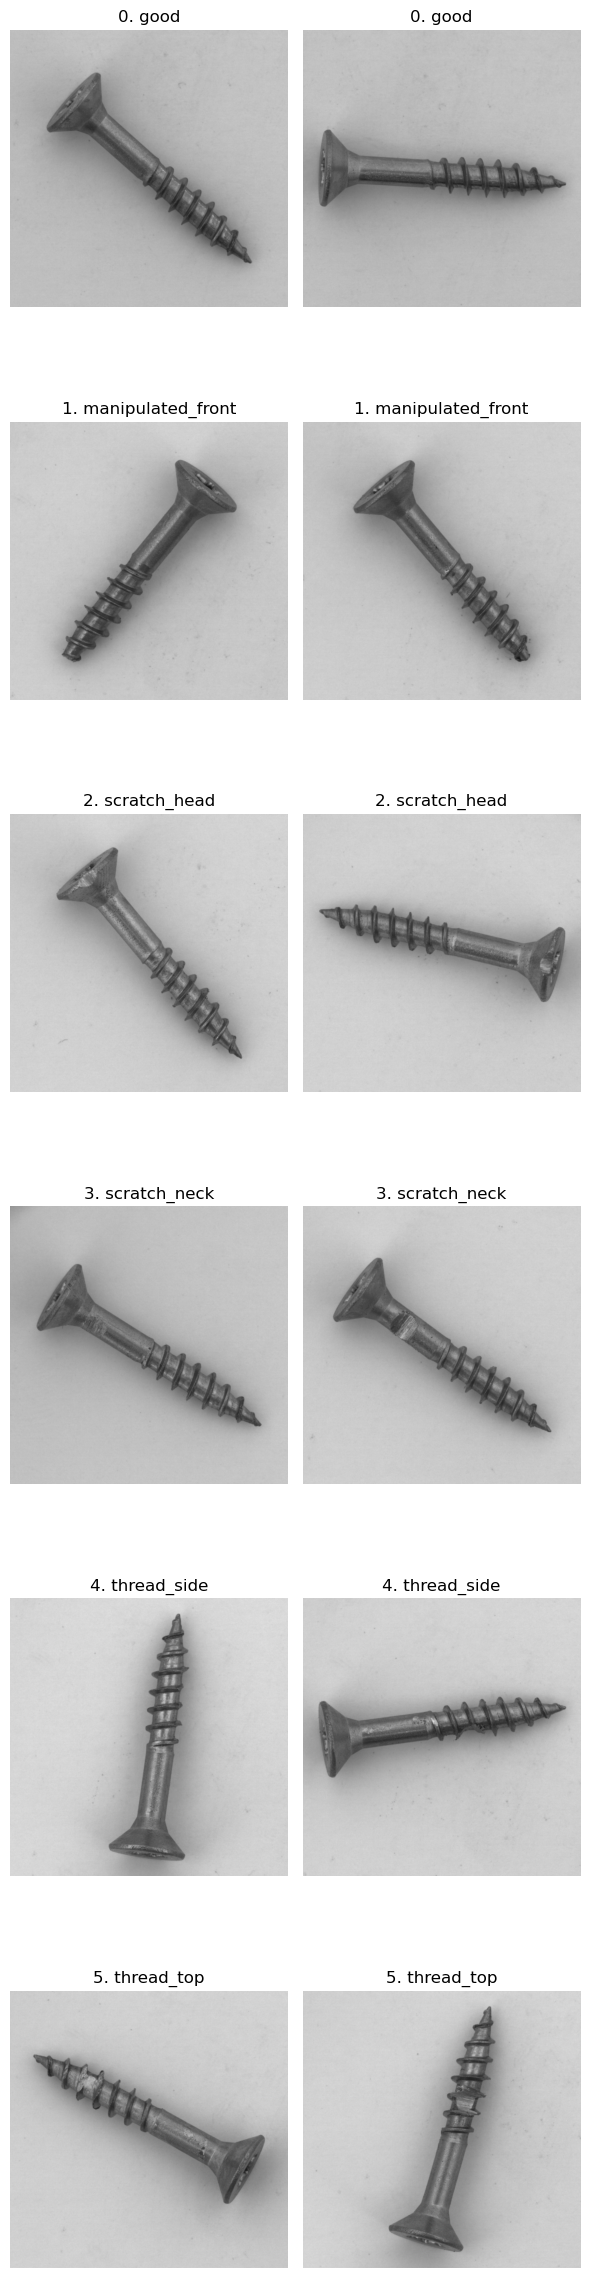

In [19]:
classes = sorted(set([path.split('\\')[2] for path in file_paths]))
print(f'Classes: {classes}')

images_per_class = len(all_data) // len(classes)
print(images_per_class)
fig, axs = plt.subplots(len(classes), 2, figsize=(6, 4 * len(classes)))

for i, class_name in enumerate(classes):
    index = i * images_per_class
    for j in range(2):
        axs[i, j].set_title(f'{i}. {class_name}')
        axs[i, j].imshow(all_data[index + j])
        axs[i, j].axis('off')

plt.tight_layout()
plt.show()

### A.Data Loading and Preprocessing

In [20]:
train_img_per_class = int(images_per_class * 0.8)
valid_img_per_class = int(images_per_class * 0.2)

x_train = []
x_valid = []

for i in range(n_classes):
    start_index = i * images_per_class
    x_train.extend(all_data[start_index : start_index+train_img_per_class])
    x_valid.extend(all_data[start_index + train_img_per_class : start_index + images_per_class])

# The shape changes from (batch_size, height, width, channels) to (batch_size, channels, height, width)
x_train = np.transpose(np.array(x_train), (0, 3, 1, 2))
x_valid = np.transpose(np.array(x_valid), (0, 3, 1, 2))

y_train = np.concatenate([np.full(train_img_per_class, i) for i in range(n_classes)])
y_valid = np.concatenate([np.full(valid_img_per_class, i) for i in range(n_classes)])

print(f'Shape of x_train: {x_train.shape}')
print(f'Shape of x_val: {x_valid.shape}')
print(f'Shape of y_train: {y_train.shape}')
print(f'Shape of y_val: {y_valid.shape}')


Shape of x_train: (96, 3, 1024, 1024)
Shape of x_val: (24, 3, 1024, 1024)
Shape of y_train: (96,)
Shape of y_val: (24,)


In [21]:
train_transform = transforms.Compose([
    transforms.Resize((512,512)),
    transforms.RandomHorizontalFlip(),
    transforms.AutoAugment(),
    transforms.CenterCrop(480),
    transforms.ToTensor(),
    transforms.Normalize(mean=0.5,std=0.5)
])


In [22]:
valid_transform = transforms.Compose([
    transforms.Resize((512, 512)),
    transforms.ToTensor(),
    transforms.Normalize(mean=0.5,std=0.5)
])

In [23]:
class MyDataset(Dataset):
    def __init__(self, x, y, transform=None):
        self.x = x
        self.y = torch.from_numpy(y).long()
        self.transform = transform

    def __getitem__(self, idx):
        new_x = np.transpose(self.x[idx], (1, 2, 0))
        return self.transform(Image.fromarray(new_x)), self.y[idx]
    
    def __len__(self):
        return len(self.x)

In [24]:
train_dataset = MyDataset(x_train, y_train, train_transform)
val_dataset = MyDataset(x_valid, y_valid, valid_transform)

train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(dataset=val_dataset, batch_size=batch_size, shuffle=False)

### B.Define Model

In [25]:
from torchvision import models
model = models.regnet_y_16gf(weights='IMAGENET1K_V1')

# ConvNet as fixed feature extractor (freeze parameters)
for param in model.parameters():
    param.requires_grad = False

num_ftrs = model.fc.in_features
num_class = 6

# change # of class from 1000 into 8 in the last layer
model.fc = nn.Linear(num_ftrs, num_class)
print(model)

RegNet(
  (stem): SimpleStemIN(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (trunk_output): Sequential(
    (block1): AnyStage(
      (block1-0): ResBottleneckBlock(
        (proj): Conv2dNormActivation(
          (0): Conv2d(32, 224, kernel_size=(1, 1), stride=(2, 2), bias=False)
          (1): BatchNorm2d(224, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
        (f): BottleneckTransform(
          (a): Conv2dNormActivation(
            (0): Conv2d(32, 224, kernel_size=(1, 1), stride=(1, 1), bias=False)
            (1): BatchNorm2d(224, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): ReLU(inplace=True)
          )
          (b): Conv2dNormActivation(
            (0): Conv2d(224, 224, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), groups=2, bias=False)
      

In [26]:
# from torchvision.models import regnet_y_16gf,RegNet_Y_16GF_Weights

# weights = RegNet_Y_16GF_Weights.IMAGENET1K_V1
# preprocess = weights.transforms()
# model = regnet_y_16gf(weights = weights,progress = True)

### C.Training the model

In [27]:
from torch.optim.lr_scheduler import CosineAnnealingLR

model = model.to(device)
optimizer = optim.Adam(model.parameters(),lr=lr)
loss_fn = nn.CrossEntropyLoss()
lr_scheduler = CosineAnnealingLR(optimizer, T_max=len(train_loader)*n_epochs, eta_min=0)

In [28]:
train_loss = []
valid_loss = []
train_acc = []
valid_acc = []

best_valid_loss = float('inf')
best_valid_acc = -1

for epoch in tqdm(range(n_epochs)):
    model.train()
    total_train_loss =0.0
    train_correct = 0
    total_train_samples =0

    for images, labels in train_loader:
        images = images.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        labels = labels.long()

        loss = loss_fn(outputs, labels)
        loss.backward()
        optimizer.step()
        total_train_loss += loss.item()

        train_predicted = outputs.argmax(-1)
        train_correct += (train_predicted == labels).sum().item()
        total_train_samples += labels.size(0)

    avg_train_loss = total_train_loss / len(train_loader)
    train_accuracy = 100. * train_correct / total_train_samples


    ##validation
    model.eval()
    total_val_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in val_loader:
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)

            labels = labels.long()
            loss = loss_fn(outputs, labels)
            total_val_loss += loss.item()

            predicted = outputs.argmax(-1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

    avg_val_loss = total_val_loss / len(val_loader)
    valid_accuracy = 100. * correct / total

    lr_scheduler.step()

    # Checkpoint
    if avg_val_loss < best_valid_loss:
        best_valid_loss = avg_val_loss

    if valid_accuracy > best_valid_acc:
        best_valid_acc = valid_accuracy
        torch.save(model.state_dict(), 'model_classification.pth')

    print(f'Epoch {epoch+1}/{n_epochs}, Train loss: {avg_train_loss:.4f}, Train acc: {train_accuracy:.4f}%, Val loss: {avg_val_loss:.4f}, Val acc: {valid_accuracy:.4f}%, Best Val loss: {best_valid_loss:.4f} Best Val acc: {best_valid_acc:.2f}%')

    # Store performance
    train_loss.append(avg_train_loss)
    train_acc.append(train_accuracy)
    valid_loss.append(avg_val_loss)
    valid_acc.append(valid_accuracy)

  1%|▏         | 1/80 [00:15<20:51, 15.84s/it]

Epoch 1/80, Train loss: 11.4070, Train acc: 14.5833%, Val loss: 4.8396, Val acc: 16.6667%, Best Val loss: 4.8396 Best Val acc: 16.67%


  2%|▎         | 2/80 [00:31<20:14, 15.58s/it]

Epoch 2/80, Train loss: 9.1276, Train acc: 13.5417%, Val loss: 4.7654, Val acc: 16.6667%, Best Val loss: 4.7654 Best Val acc: 16.67%


  4%|▍         | 3/80 [00:46<19:58, 15.56s/it]

Epoch 3/80, Train loss: 6.4871, Train acc: 16.6667%, Val loss: 2.8713, Val acc: 16.6667%, Best Val loss: 2.8713 Best Val acc: 16.67%


  5%|▌         | 4/80 [01:02<20:01, 15.81s/it]

Epoch 4/80, Train loss: 4.2995, Train acc: 25.0000%, Val loss: 2.7818, Val acc: 25.0000%, Best Val loss: 2.7818 Best Val acc: 25.00%


  6%|▋         | 5/80 [01:18<19:43, 15.77s/it]

Epoch 5/80, Train loss: 4.1419, Train acc: 15.6250%, Val loss: 2.6632, Val acc: 16.6667%, Best Val loss: 2.6632 Best Val acc: 25.00%


  8%|▊         | 6/80 [01:37<20:46, 16.85s/it]

Epoch 6/80, Train loss: 2.8760, Train acc: 23.9583%, Val loss: 2.4632, Val acc: 37.5000%, Best Val loss: 2.4632 Best Val acc: 37.50%


  9%|▉         | 7/80 [01:53<20:03, 16.48s/it]

Epoch 7/80, Train loss: 2.4192, Train acc: 26.0417%, Val loss: 2.1209, Val acc: 20.8333%, Best Val loss: 2.1209 Best Val acc: 37.50%


 10%|█         | 8/80 [02:08<19:25, 16.18s/it]

Epoch 8/80, Train loss: 2.0713, Train acc: 31.2500%, Val loss: 2.2047, Val acc: 20.8333%, Best Val loss: 2.1209 Best Val acc: 37.50%


 11%|█▏        | 9/80 [02:24<18:58, 16.04s/it]

Epoch 9/80, Train loss: 2.2173, Train acc: 22.9167%, Val loss: 2.6897, Val acc: 33.3333%, Best Val loss: 2.1209 Best Val acc: 37.50%


 12%|█▎        | 10/80 [02:40<18:34, 15.92s/it]

Epoch 10/80, Train loss: 2.1035, Train acc: 31.2500%, Val loss: 2.0188, Val acc: 16.6667%, Best Val loss: 2.0188 Best Val acc: 37.50%


 14%|█▍        | 11/80 [02:55<18:12, 15.83s/it]

Epoch 11/80, Train loss: 2.0498, Train acc: 33.3333%, Val loss: 2.7421, Val acc: 37.5000%, Best Val loss: 2.0188 Best Val acc: 37.50%


 15%|█▌        | 12/80 [03:11<17:49, 15.73s/it]

Epoch 12/80, Train loss: 2.5619, Train acc: 22.9167%, Val loss: 1.8713, Val acc: 20.8333%, Best Val loss: 1.8713 Best Val acc: 37.50%


 16%|█▋        | 13/80 [03:27<17:31, 15.70s/it]

Epoch 13/80, Train loss: 2.1634, Train acc: 20.8333%, Val loss: 1.6352, Val acc: 29.1667%, Best Val loss: 1.6352 Best Val acc: 37.50%


 18%|█▊        | 14/80 [03:42<17:18, 15.73s/it]

Epoch 14/80, Train loss: 1.7936, Train acc: 27.0833%, Val loss: 1.7137, Val acc: 37.5000%, Best Val loss: 1.6352 Best Val acc: 37.50%


 19%|█▉        | 15/80 [03:58<17:09, 15.84s/it]

Epoch 15/80, Train loss: 1.5270, Train acc: 37.5000%, Val loss: 1.8010, Val acc: 41.6667%, Best Val loss: 1.6352 Best Val acc: 41.67%


 20%|██        | 16/80 [04:14<16:49, 15.77s/it]

Epoch 16/80, Train loss: 1.7125, Train acc: 41.6667%, Val loss: 2.6042, Val acc: 29.1667%, Best Val loss: 1.6352 Best Val acc: 41.67%


 21%|██▏       | 17/80 [04:30<16:33, 15.77s/it]

Epoch 17/80, Train loss: 2.2893, Train acc: 31.2500%, Val loss: 1.7240, Val acc: 25.0000%, Best Val loss: 1.6352 Best Val acc: 41.67%


 22%|██▎       | 18/80 [04:46<16:23, 15.86s/it]

Epoch 18/80, Train loss: 2.4279, Train acc: 32.2917%, Val loss: 2.2937, Val acc: 45.8333%, Best Val loss: 1.6352 Best Val acc: 45.83%


 24%|██▍       | 19/80 [05:01<15:59, 15.73s/it]

Epoch 19/80, Train loss: 2.4764, Train acc: 27.0833%, Val loss: 2.4623, Val acc: 25.0000%, Best Val loss: 1.6352 Best Val acc: 45.83%


 25%|██▌       | 20/80 [05:17<15:39, 15.66s/it]

Epoch 20/80, Train loss: 2.8325, Train acc: 28.1250%, Val loss: 2.3120, Val acc: 45.8333%, Best Val loss: 1.6352 Best Val acc: 45.83%


 26%|██▋       | 21/80 [05:32<15:22, 15.64s/it]

Epoch 21/80, Train loss: 2.0517, Train acc: 32.2917%, Val loss: 1.7935, Val acc: 33.3333%, Best Val loss: 1.6352 Best Val acc: 45.83%


 28%|██▊       | 22/80 [05:48<15:03, 15.57s/it]

Epoch 22/80, Train loss: 2.2499, Train acc: 33.3333%, Val loss: 2.5800, Val acc: 37.5000%, Best Val loss: 1.6352 Best Val acc: 45.83%


 29%|██▉       | 23/80 [06:03<14:46, 15.55s/it]

Epoch 23/80, Train loss: 2.8798, Train acc: 28.1250%, Val loss: 2.8406, Val acc: 33.3333%, Best Val loss: 1.6352 Best Val acc: 45.83%


 30%|███       | 24/80 [06:19<14:28, 15.51s/it]

Epoch 24/80, Train loss: 2.2571, Train acc: 44.7917%, Val loss: 1.6765, Val acc: 29.1667%, Best Val loss: 1.6352 Best Val acc: 45.83%


 31%|███▏      | 25/80 [06:34<14:13, 15.52s/it]

Epoch 25/80, Train loss: 2.4585, Train acc: 28.1250%, Val loss: 1.4162, Val acc: 25.0000%, Best Val loss: 1.4162 Best Val acc: 45.83%


 32%|███▎      | 26/80 [06:50<13:57, 15.50s/it]

Epoch 26/80, Train loss: 2.1176, Train acc: 40.6250%, Val loss: 1.9703, Val acc: 12.5000%, Best Val loss: 1.4162 Best Val acc: 45.83%


 34%|███▍      | 27/80 [07:05<13:40, 15.47s/it]

Epoch 27/80, Train loss: 2.1943, Train acc: 31.2500%, Val loss: 2.0749, Val acc: 29.1667%, Best Val loss: 1.4162 Best Val acc: 45.83%


 35%|███▌      | 28/80 [07:21<13:25, 15.49s/it]

Epoch 28/80, Train loss: 2.7042, Train acc: 28.1250%, Val loss: 1.9832, Val acc: 45.8333%, Best Val loss: 1.4162 Best Val acc: 45.83%


 36%|███▋      | 29/80 [07:36<13:08, 15.46s/it]

Epoch 29/80, Train loss: 1.7512, Train acc: 37.5000%, Val loss: 1.8403, Val acc: 45.8333%, Best Val loss: 1.4162 Best Val acc: 45.83%


 38%|███▊      | 30/80 [07:52<12:56, 15.52s/it]

Epoch 30/80, Train loss: 1.8820, Train acc: 38.5417%, Val loss: 1.9142, Val acc: 20.8333%, Best Val loss: 1.4162 Best Val acc: 45.83%


 39%|███▉      | 31/80 [08:07<12:41, 15.55s/it]

Epoch 31/80, Train loss: 2.0312, Train acc: 35.4167%, Val loss: 2.0414, Val acc: 41.6667%, Best Val loss: 1.4162 Best Val acc: 45.83%


 40%|████      | 32/80 [08:23<12:26, 15.55s/it]

Epoch 32/80, Train loss: 2.0156, Train acc: 34.3750%, Val loss: 1.7174, Val acc: 37.5000%, Best Val loss: 1.4162 Best Val acc: 45.83%


 41%|████▏     | 33/80 [08:38<12:08, 15.50s/it]

Epoch 33/80, Train loss: 2.2778, Train acc: 27.0833%, Val loss: 2.0830, Val acc: 33.3333%, Best Val loss: 1.4162 Best Val acc: 45.83%


 42%|████▎     | 34/80 [08:54<11:55, 15.56s/it]

Epoch 34/80, Train loss: 2.4545, Train acc: 38.5417%, Val loss: 1.6011, Val acc: 25.0000%, Best Val loss: 1.4162 Best Val acc: 45.83%


 44%|████▍     | 35/80 [09:10<11:41, 15.60s/it]

Epoch 35/80, Train loss: 2.7425, Train acc: 32.2917%, Val loss: 1.6357, Val acc: 37.5000%, Best Val loss: 1.4162 Best Val acc: 45.83%


 45%|████▌     | 36/80 [09:25<11:24, 15.57s/it]

Epoch 36/80, Train loss: 2.0634, Train acc: 26.0417%, Val loss: 1.6890, Val acc: 41.6667%, Best Val loss: 1.4162 Best Val acc: 45.83%


 46%|████▋     | 37/80 [09:41<11:07, 15.51s/it]

Epoch 37/80, Train loss: 1.7799, Train acc: 44.7917%, Val loss: 1.3271, Val acc: 41.6667%, Best Val loss: 1.3271 Best Val acc: 45.83%


 48%|████▊     | 38/80 [09:56<10:51, 15.51s/it]

Epoch 38/80, Train loss: 1.6794, Train acc: 41.6667%, Val loss: 2.0159, Val acc: 41.6667%, Best Val loss: 1.3271 Best Val acc: 45.83%


 49%|████▉     | 39/80 [10:12<10:38, 15.57s/it]

Epoch 39/80, Train loss: 1.6572, Train acc: 42.7083%, Val loss: 1.7113, Val acc: 41.6667%, Best Val loss: 1.3271 Best Val acc: 45.83%


 50%|█████     | 40/80 [10:28<10:27, 15.69s/it]

Epoch 40/80, Train loss: 1.7258, Train acc: 36.4583%, Val loss: 1.3148, Val acc: 54.1667%, Best Val loss: 1.3148 Best Val acc: 54.17%


 51%|█████▏    | 41/80 [10:43<10:08, 15.60s/it]

Epoch 41/80, Train loss: 1.4660, Train acc: 51.0417%, Val loss: 1.6113, Val acc: 41.6667%, Best Val loss: 1.3148 Best Val acc: 54.17%


 52%|█████▎    | 42/80 [10:58<09:47, 15.47s/it]

Epoch 42/80, Train loss: 1.3538, Train acc: 52.0833%, Val loss: 1.6953, Val acc: 25.0000%, Best Val loss: 1.3148 Best Val acc: 54.17%


 54%|█████▍    | 43/80 [11:14<09:30, 15.42s/it]

Epoch 43/80, Train loss: 1.8987, Train acc: 40.6250%, Val loss: 1.6858, Val acc: 41.6667%, Best Val loss: 1.3148 Best Val acc: 54.17%


 55%|█████▌    | 44/80 [11:29<09:16, 15.46s/it]

Epoch 44/80, Train loss: 1.9878, Train acc: 48.9583%, Val loss: 1.5669, Val acc: 45.8333%, Best Val loss: 1.3148 Best Val acc: 54.17%


 56%|█████▋    | 45/80 [11:45<09:01, 15.48s/it]

Epoch 45/80, Train loss: 1.5118, Train acc: 47.9167%, Val loss: 1.4279, Val acc: 50.0000%, Best Val loss: 1.3148 Best Val acc: 54.17%


 57%|█████▊    | 46/80 [12:00<08:46, 15.48s/it]

Epoch 46/80, Train loss: 1.8972, Train acc: 46.8750%, Val loss: 1.5415, Val acc: 37.5000%, Best Val loss: 1.3148 Best Val acc: 54.17%


 59%|█████▉    | 47/80 [12:16<08:31, 15.51s/it]

Epoch 47/80, Train loss: 1.7592, Train acc: 34.3750%, Val loss: 1.7385, Val acc: 37.5000%, Best Val loss: 1.3148 Best Val acc: 54.17%


 60%|██████    | 48/80 [12:32<08:19, 15.61s/it]

Epoch 48/80, Train loss: 2.0899, Train acc: 42.7083%, Val loss: 1.9896, Val acc: 45.8333%, Best Val loss: 1.3148 Best Val acc: 54.17%


 61%|██████▏   | 49/80 [12:47<08:01, 15.52s/it]

Epoch 49/80, Train loss: 2.1754, Train acc: 39.5833%, Val loss: 1.9161, Val acc: 33.3333%, Best Val loss: 1.3148 Best Val acc: 54.17%


 62%|██████▎   | 50/80 [13:02<07:44, 15.47s/it]

Epoch 50/80, Train loss: 2.0657, Train acc: 36.4583%, Val loss: 1.7907, Val acc: 20.8333%, Best Val loss: 1.3148 Best Val acc: 54.17%


 64%|██████▍   | 51/80 [13:18<07:27, 15.45s/it]

Epoch 51/80, Train loss: 1.8894, Train acc: 45.8333%, Val loss: 2.1623, Val acc: 45.8333%, Best Val loss: 1.3148 Best Val acc: 54.17%


 65%|██████▌   | 52/80 [13:33<07:12, 15.44s/it]

Epoch 52/80, Train loss: 1.7886, Train acc: 41.6667%, Val loss: 1.4808, Val acc: 54.1667%, Best Val loss: 1.3148 Best Val acc: 54.17%


 66%|██████▋   | 53/80 [13:49<06:57, 15.48s/it]

Epoch 53/80, Train loss: 1.4598, Train acc: 44.7917%, Val loss: 1.7663, Val acc: 25.0000%, Best Val loss: 1.3148 Best Val acc: 54.17%


 68%|██████▊   | 54/80 [14:04<06:43, 15.51s/it]

Epoch 54/80, Train loss: 1.5802, Train acc: 55.2083%, Val loss: 1.5957, Val acc: 37.5000%, Best Val loss: 1.3148 Best Val acc: 54.17%


 69%|██████▉   | 55/80 [14:20<06:29, 15.58s/it]

Epoch 55/80, Train loss: 1.6847, Train acc: 48.9583%, Val loss: 2.0960, Val acc: 50.0000%, Best Val loss: 1.3148 Best Val acc: 54.17%


 70%|███████   | 56/80 [14:36<06:15, 15.65s/it]

Epoch 56/80, Train loss: 2.0119, Train acc: 34.3750%, Val loss: 1.5351, Val acc: 37.5000%, Best Val loss: 1.3148 Best Val acc: 54.17%


 71%|███████▏  | 57/80 [14:51<05:58, 15.58s/it]

Epoch 57/80, Train loss: 2.0794, Train acc: 43.7500%, Val loss: 1.9133, Val acc: 45.8333%, Best Val loss: 1.3148 Best Val acc: 54.17%


 72%|███████▎  | 58/80 [15:07<05:43, 15.62s/it]

Epoch 58/80, Train loss: 2.0159, Train acc: 41.6667%, Val loss: 2.5579, Val acc: 45.8333%, Best Val loss: 1.3148 Best Val acc: 54.17%


 74%|███████▍  | 59/80 [15:23<05:28, 15.63s/it]

Epoch 59/80, Train loss: 1.8757, Train acc: 44.7917%, Val loss: 1.4546, Val acc: 37.5000%, Best Val loss: 1.3148 Best Val acc: 54.17%


 75%|███████▌  | 60/80 [15:38<05:11, 15.60s/it]

Epoch 60/80, Train loss: 1.7393, Train acc: 41.6667%, Val loss: 1.7585, Val acc: 20.8333%, Best Val loss: 1.3148 Best Val acc: 54.17%


 76%|███████▋  | 61/80 [15:53<04:53, 15.47s/it]

Epoch 61/80, Train loss: 1.5604, Train acc: 47.9167%, Val loss: 2.9865, Val acc: 33.3333%, Best Val loss: 1.3148 Best Val acc: 54.17%


 78%|███████▊  | 62/80 [16:09<04:41, 15.64s/it]

Epoch 62/80, Train loss: 2.3202, Train acc: 43.7500%, Val loss: 1.2906, Val acc: 62.5000%, Best Val loss: 1.2906 Best Val acc: 62.50%


 79%|███████▉  | 63/80 [16:25<04:24, 15.56s/it]

Epoch 63/80, Train loss: 1.5402, Train acc: 33.3333%, Val loss: 1.5696, Val acc: 54.1667%, Best Val loss: 1.2906 Best Val acc: 62.50%


 80%|████████  | 64/80 [16:40<04:08, 15.52s/it]

Epoch 64/80, Train loss: 1.4862, Train acc: 48.9583%, Val loss: 2.3092, Val acc: 29.1667%, Best Val loss: 1.2906 Best Val acc: 62.50%


 81%|████████▏ | 65/80 [16:56<03:52, 15.51s/it]

Epoch 65/80, Train loss: 1.7388, Train acc: 40.6250%, Val loss: 1.9312, Val acc: 45.8333%, Best Val loss: 1.2906 Best Val acc: 62.50%


 82%|████████▎ | 66/80 [17:11<03:36, 15.46s/it]

Epoch 66/80, Train loss: 1.5732, Train acc: 44.7917%, Val loss: 1.5246, Val acc: 50.0000%, Best Val loss: 1.2906 Best Val acc: 62.50%


 84%|████████▍ | 67/80 [17:27<03:21, 15.51s/it]

Epoch 67/80, Train loss: 1.1831, Train acc: 58.3333%, Val loss: 1.6316, Val acc: 41.6667%, Best Val loss: 1.2906 Best Val acc: 62.50%


 85%|████████▌ | 68/80 [17:42<03:06, 15.51s/it]

Epoch 68/80, Train loss: 1.6900, Train acc: 53.1250%, Val loss: 1.7108, Val acc: 54.1667%, Best Val loss: 1.2906 Best Val acc: 62.50%


 86%|████████▋ | 69/80 [17:58<02:50, 15.54s/it]

Epoch 69/80, Train loss: 1.4433, Train acc: 51.0417%, Val loss: 1.3583, Val acc: 50.0000%, Best Val loss: 1.2906 Best Val acc: 62.50%


 88%|████████▊ | 70/80 [18:13<02:35, 15.51s/it]

Epoch 70/80, Train loss: 1.7682, Train acc: 50.0000%, Val loss: 1.7598, Val acc: 29.1667%, Best Val loss: 1.2906 Best Val acc: 62.50%


 89%|████████▉ | 71/80 [18:28<02:19, 15.48s/it]

Epoch 71/80, Train loss: 1.9454, Train acc: 50.0000%, Val loss: 1.6149, Val acc: 41.6667%, Best Val loss: 1.2906 Best Val acc: 62.50%


 90%|█████████ | 72/80 [18:44<02:03, 15.50s/it]

Epoch 72/80, Train loss: 1.2123, Train acc: 55.2083%, Val loss: 1.3589, Val acc: 45.8333%, Best Val loss: 1.2906 Best Val acc: 62.50%


 91%|█████████▏| 73/80 [19:00<01:48, 15.51s/it]

Epoch 73/80, Train loss: 1.2203, Train acc: 61.4583%, Val loss: 2.1650, Val acc: 33.3333%, Best Val loss: 1.2906 Best Val acc: 62.50%


 92%|█████████▎| 74/80 [19:15<01:32, 15.48s/it]

Epoch 74/80, Train loss: 1.9142, Train acc: 39.5833%, Val loss: 1.8214, Val acc: 50.0000%, Best Val loss: 1.2906 Best Val acc: 62.50%


 94%|█████████▍| 75/80 [19:31<01:17, 15.52s/it]

Epoch 75/80, Train loss: 1.7720, Train acc: 51.0417%, Val loss: 1.5899, Val acc: 50.0000%, Best Val loss: 1.2906 Best Val acc: 62.50%


 95%|█████████▌| 76/80 [19:46<01:02, 15.53s/it]

Epoch 76/80, Train loss: 1.3115, Train acc: 51.0417%, Val loss: 1.1559, Val acc: 58.3333%, Best Val loss: 1.1559 Best Val acc: 62.50%


 96%|█████████▋| 77/80 [20:02<00:46, 15.53s/it]

Epoch 77/80, Train loss: 1.3347, Train acc: 53.1250%, Val loss: 1.7634, Val acc: 45.8333%, Best Val loss: 1.1559 Best Val acc: 62.50%


 98%|█████████▊| 78/80 [20:17<00:31, 15.59s/it]

Epoch 78/80, Train loss: 1.4701, Train acc: 52.0833%, Val loss: 1.3776, Val acc: 50.0000%, Best Val loss: 1.1559 Best Val acc: 62.50%


 99%|█████████▉| 79/80 [20:33<00:15, 15.54s/it]

Epoch 79/80, Train loss: 1.5181, Train acc: 54.1667%, Val loss: 1.5386, Val acc: 54.1667%, Best Val loss: 1.1559 Best Val acc: 62.50%


100%|██████████| 80/80 [20:48<00:00, 15.61s/it]

Epoch 80/80, Train loss: 1.7414, Train acc: 46.8750%, Val loss: 1.4996, Val acc: 50.0000%, Best Val loss: 1.1559 Best Val acc: 62.50%


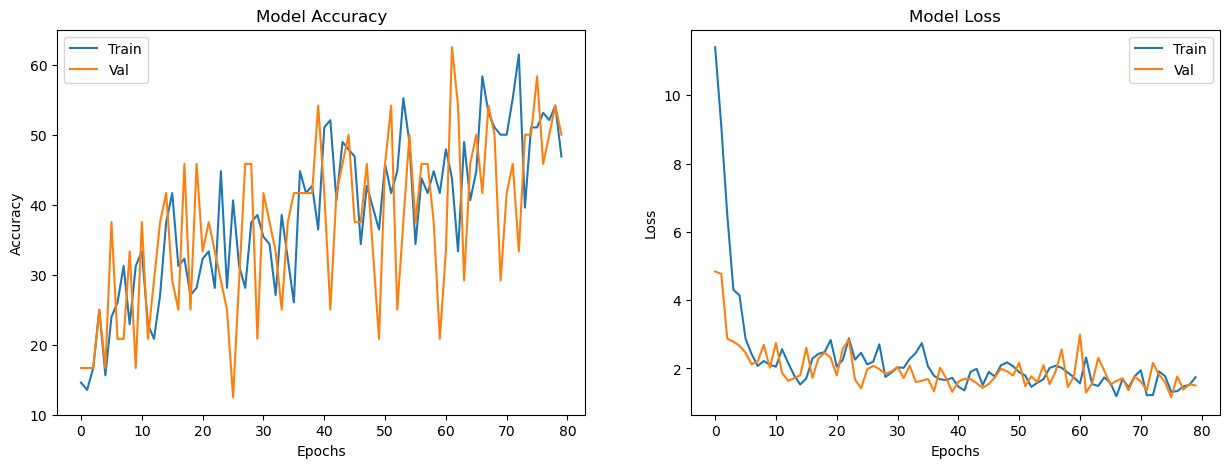

In [29]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 2, figsize=(15, 5))

# Plotting training and validation accuracy
ax[0].plot(train_acc)
ax[0].plot(valid_acc)
ax[0].set_title('Model Accuracy')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Accuracy')
ax[0].legend(['Train', 'Val'])

# Plotting training and validation loss
ax[1].plot(train_loss)
ax[1].plot(valid_loss)
ax[1].set_title('Model Loss')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Loss')
ax[1].legend(['Train', 'Val'])

plt.show()

In [30]:
# Load the trained weights
model.load_state_dict(torch.load('model_classification.pth'))

# Set the model to evaluation mode
model.eval()

test_correct = 0
test_total = 0

with torch.no_grad():
    for images, labels in val_loader:

        images = images.to(device)
        labels = labels.to(device)

        labels = labels.long()

        outputs = model(images)

        predicted = outputs.argmax(-1)
        print(predicted)
        print(labels)
        test_correct += (predicted == labels).sum().item()
        test_total += labels.size(0)

print(f'Test accuracy is {100. * test_correct / test_total}%')

tensor([0, 0, 0, 0, 1, 4, 2, 0, 2, 2, 2, 2, 3, 3, 4, 2], device='cuda:0')
tensor([0, 0, 0, 0, 1, 1, 1, 1, 2, 2, 2, 2, 3, 3, 3, 3], device='cuda:0')
tensor([4, 5, 2, 4, 2, 2, 5, 5], device='cuda:0')
tensor([4, 4, 4, 4, 5, 5, 5, 5], device='cuda:0')
Test accuracy is 62.5%
